### Final Project  
Course:  
Semester: Summer 2025  
Institution: University of San Diego  
  
### Project Details  
Project Title:  
Authors: Greg Moore, Zachary Artman, Jack Baxter  
Instructor: David Friesen  
Submission Date: 06/23/2025  

### Project Description  
  
### Dependencies  
Python [3.9 or higher]
Jupyter Notebook
Libraries: [pandas, numpy, scikit-learn, matplotlib]

In [ ]:
#import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from xgboost import XGBClassifier, plot_importance

In [ ]:
#create dataframe
airlinedata = pd.read_csv('flights.csv')
airlinedata.head()

/var/folders/1n/_cb8t5dx72q4m291_299s1d00000gn/T/ipykernel_49090/2368770430.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  airlinedata = pd.read_csv('flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#data summary and column description
sum = airlinedata.shape #shape data
print("airlinedata(row, col):",sum,"\r\n") 
for col in airlinedata.columns: #print data by col 
    print(airlinedata[col].describe()) 

airlinedata(row, col): (5819079, 31) 

count    5819079.0
mean        2015.0
std            0.0
min         2015.0
25%         2015.0
50%         2015.0
75%         2015.0
max         2015.0
Name: YEAR, dtype: float64
count    5.819079e+06
mean     6.524085e+00
std      3.405137e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.200000e+01
Name: MONTH, dtype: float64
count    5.819079e+06
mean     1.570459e+01
std      8.783425e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.600000e+01
75%      2.300000e+01
max      3.100000e+01
Name: DAY, dtype: float64
count    5.819079e+06
mean     3.926941e+00
std      1.988845e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      7.000000e+00
Name: DAY_OF_WEEK, dtype: float64
count     5819079
unique         14
top            WN
freq      1261855
Name: AIRLINE, dtype: object
count    5.819079e+06
mean     2.173093e+03
std      1.757064e+03

In [ ]:
#explore variables / remove uneccessary delay categories 
cols = list(airlinedata.columns)
i = 0
for vals in cols: 
    print(cols[i])
    i = i+1

YEAR
MONTH
DAY
DAY_OF_WEEK
AIRLINE
FLIGHT_NUMBER
TAIL_NUMBER
ORIGIN_AIRPORT
DESTINATION_AIRPORT
SCHEDULED_DEPARTURE
DEPARTURE_TIME
DEPARTURE_DELAY
TAXI_OUT
WHEELS_OFF
SCHEDULED_TIME
ELAPSED_TIME
AIR_TIME
DISTANCE
WHEELS_ON
TAXI_IN
SCHEDULED_ARRIVAL
ARRIVAL_TIME
ARRIVAL_DELAY
DIVERTED
CANCELLED
CANCELLATION_REASON
AIR_SYSTEM_DELAY
SECURITY_DELAY
AIRLINE_DELAY
LATE_AIRCRAFT_DELAY
WEATHER_DELAY


In [ ]:
nons = ['WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY', 'AIRLINE_DELAY', 'SECURITY_DELAY', 'AIR_SYSTEM_DELAY']
airlinedata.drop(nons, axis=1, inplace=True)

In [ ]:
#remove unecessary information and drop NAN values 
shape = airlinedata.shape #shape data
print(shape)

(0, 26)


In [ ]:
#target identification and initialization 
ydelay = airlinedata.Delay #target is instance of delay 
xfeatures = airlinedata.drop(columns=['Delay']) #remaining vars are features 

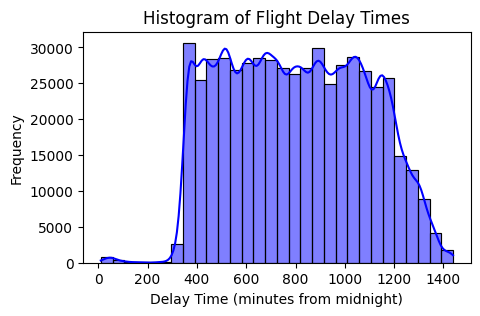

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(airlinedata['Time'], bins=30, kde=True, color='blue')
plt.title('Histogram of Flight Delay Times')
plt.xlabel('Delay Time (minutes from midnight)')
plt.ylabel('Frequency')
plt.show()